In [ ]:
%matplotlib inline

import sys
sys.path.append('/home/ngr/gdrive/wearables/scripts')
import data as weardata

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# sktime, API REF: https://www.sktime.org/en/latest/api_reference.html
from sktime.classification.compose import ComposableTimeSeriesForestClassifier
from sktime.utils.data_processing import from_2d_array_to_nested
from sktime.regression.compose import ComposableTimeSeriesForestRegressor
from sktime.regression.interval_based import TimeSeriesForestRegressor
from sktime.classification.dictionary_based import ContractableBOSS
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.classification.hybrid import HIVECOTEV1
from sktime.classification.interval_based import RandomIntervalSpectralForest
from sktime.classification.shapelet_based import ShapeletTransformClassifier


# eval
from sklearn.metrics import mean_absolute_error

# model selection
from sklearn.model_selection import KFold

In [124]:
data = weardata.get_train_test()
X_train, y_train, X_test, y_test = data['X_train'], data['y_train'], data['X_test'], data['y_test']

print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

X_train:  (2145, 1440)
y_train:  (2145,)
X_test:  (541, 1440)
y_test:  (541,)


In [125]:
# convert into sktime format, i.e., convert to dataframe, with time-series held in a column (one col per uni-variate time-series data)
X_train_df = from_2d_array_to_nested(X_train)
X_test_df = from_2d_array_to_nested(X_test)
X_train_df.head()

,0
0,0 0.0 1 0.0 2 0.0 3 0....
1,0 0.0 1 0.0 2 0.0 3 0....
2,0 0.000000 1 0.000000 2 0.00...
3,0 0.000000 1 0.000000 2 0.00...
4,0 0.000000 1 0.000000 2 0.00...


## exploration

Look into how many samples in training set we have for each GA (in weeks)

In [71]:
savefigs = True

[ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20.
 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38.] [  1   9  24  49  89 158 100  78  80 117  60  56  63  70  31  41  38  51
  28  40  82 157  68  33  28  44  18  27  35  84 103 168  55  50   9   1]


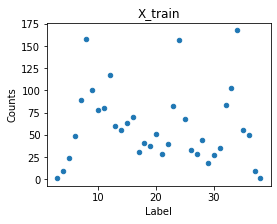

In [127]:
labels, counts = np.unique(y_train, return_counts=True)
print(labels, counts)

# viz
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.scatter(labels, counts, s=20)

ax.set_xlabel('Label')
ax.set_ylabel('Counts')
ax.set_title('X_train')

if savefigs:
    fig.savefig(os.path.join(os.getcwd(), '../results/scatter_countsVlabels.png'), bbox_inches='tight', dpi=600)

In [270]:
def actigraphy_sktime(X_train_df, y_train, X_test_df, y_test, sk_modelclass, 
                      exp = 'TimeSeriesForest_GAregression', kfolds=5, 
                      verbose=True):
    '''Run sktime models on GA data
    
    TODO (ngr):
      1. add out_file storage in addition (or instead of) printing results
    '''
    if verbose:
        tic = time.time()
        print('Starting {} experiment...'.format(exp))
    models = {} # (tuple): (model, eval_criterion) where eval_criterion = MAE here

    kf = KFold(n_splits=kfolds, shuffle=True)
    for i, (train_idx, val_idx) in enumerate(kf.split(np.arange(X_train_df.shape[0]))):
        if verbose:
            sub_tic = time.time()
        X_train_df_cv, y_train_cv = X_train_df.iloc[train_idx, :], y_train[train_idx]
        X_val_df, y_val = X_train_df.iloc[val_idx, :], y_train[val_idx]

        # init model
        model = sk_modelclass # ComposableTimeSeriesForestRegressor()

        # fit, eval, store
        model.fit(X_train_df_cv, y_train_cv)
        mae = mean_absolute_error(y_val, model.predict(X_val_df))
        models['CV{}'.format(i)] = (model, mae)
        del model
        
        if verbose:
            print('  k={}-fold finished in {:.1f}-s\ttotal_time_elapsed: {:.1f}-min'.format(i, time.time()-sub_tic, (time.time()-tic)/60))

    # store in file
    print('\n... finished in {:.1f}-min'.format((time.time()-tic)/60))
    print('\n----')
    print('{} results:'.format(exp))
    print('  <MAE>_{}folds: {:.4f}\tSD_{}folds: {:.1f}'.format(kfolds, np.mean([v[1] for k,v in models.items()]), kfolds, np.std([v[1] for k,v in models.items()])))
    print('  MAE_test: {:.4f}'.format(mean_absolute_error(y_test, models['CV{}'.format(np.argmax([v[1] for k,v in models.items()]))][0].predict(X_test_df))))
    print('----')
    
    return models

In [90]:
# slow after 1fold, not sure why
cboss = actigraphy_sktime(X_train_df, y_train, X_test_df, y_test, 
                           ContractableBOSS(time_limit=1., n_jobs=-1), 
                           exp='ContractableBOSS_GAclass')

In [95]:
knndtw = actigraphy_sktime(X_train_df, y_train, X_test_df, y_test, 
                           KNeighborsTimeSeriesClassifier(n_neighbors=3, weights='distance'), 
                           exp='kNNDTW_GAclass')

Starting kNNDTW_GAclass experiment...


In [271]:
# another bug?
compTSFR = actigraphy_sktime(X_train_df, y_train, X_test_df, y_test, 
                           ComposableTimeSeriesForestRegressor(), 
                           exp='compTSFR_GAreg')

Starting compTSFR_GAreg experiment...


AttributeError: 'DataFrame' object has no attribute 'dtype'

In [279]:
TSFR = actigraphy_sktime(X_train_df, y_train, X_test_df, y_test, 
                           TimeSeriesForestRegressor(), 
                           exp='TSFR_GAreg')

Starting TSFR_GAreg experiment...
  k=0-fold finished in 58.9-s	total_time_elapsed: 1.0-min
  k=1-fold finished in 54.1-s	total_time_elapsed: 1.9-min
  k=2-fold finished in 55.3-s	total_time_elapsed: 2.8-min
  k=3-fold finished in 56.7-s	total_time_elapsed: 3.7-min
  k=4-fold finished in 54.8-s	total_time_elapsed: 4.7-min

... finished in 4.7-min

----
TSFR_GAreg results:
  <MAE>_5folds: 8.4195	SD_5folds: 0.2
  MAE_test: 8.3040
----


In [ ]:
hivecote = actigraphy_sktime(X_train_df, y_train, X_test_df, y_test, 
                           HIVECOTEV1(), 
                           exp='HIVECOTEV1_GAclass')

Starting HIVECOTEV1_GAclass experiment...


In [ ]:
rise = actigraphy_sktime(X_train_df, y_train, X_test_df, y_test, 
                           RandomIntervalSpectralForest(), 
                           exp='RISE_GAclass')

In [ ]:
shaplet = actigraphy_sktime(X_train_df, y_train, X_test_df, y_test, 
                           ShapeletTransformClassifier(), 
                           exp='shaplet_GAclass')

# bug

seems to be an error with score/predict methods of `sktime.classifiers` API

**Report** sent to `sktime` contributors, as issue#1039, see [here](https://github.com/alan-turing-institute/sktime/issues/1039)

In [255]:
import numpy as np
from sktime.utils.data_processing import from_2d_array_to_nested
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

# simulate data as sinusoid for 1000 samples, add white noise
t = np.linspace(0, 2*3.14, 2048)
x = np.repeat(np.sin(t).reshape(-1, 1), 1000, axis=1).T
x += np.random.uniform(0, 1, size=x.shape)

# convert to sktime data rep
X_train = from_2d_array_to_nested(x)

# init model
clf = KNeighborsTimeSeriesClassifier(n_neighbors=3, weights='distance')
dummy_binary = np.array(np.random.choice([0, 1], X_train.shape[0]), dtype=str)
clf.fit(X_train, dummy_binary)
clf.score(X_train, dummy_binary)
# clf.predict(X_train) # same problem as above

KeyboardInterrupt: 

In [258]:
import numpy as np
from sktime.utils.data_processing import from_2d_array_to_nested
from sktime.classification.dictionary_based import ContractableBOSS

# simulate data as sinusoid for 1000 samples, add white noise
t = np.linspace(0, 2*3.14, 2048)
x = np.repeat(np.sin(t).reshape(-1, 1), 1000, axis=1).T
x += np.random.uniform(0, 1, size=x.shape)

# convert to sktime data rep
X_train = from_2d_array_to_nested(x)

# init model
clf = ContractableBOSS(time_limit=0.5)
dummy_binary = np.array(np.random.choice([0, 1], X_train.shape[0]), dtype=str)
clf.fit(X_train, dummy_binary)
clf.score(X_train, dummy_binary)
# clf.predict(X_train) # same problem as above

KeyboardInterrupt: 

In [254]:
from sktime import show_versions; show_versions()


System:
    python: 3.8.5 (default, Jul 28 2020, 12:59:40)  [GCC 9.3.0]
executable: /usr/bin/python3
   machine: Linux-4.4.0-18362-Microsoft-x86_64-with-glibc2.29

Python dependencies:
          pip: 20.0.2
   setuptools: 45.2.0
      sklearn: 0.24.2
       sktime: 0.6.1
  statsmodels: 0.12.2
        numpy: 1.20.3
        scipy: 1.4.1
       Cython: 0.29.23
       pandas: 1.2.4
   matplotlib: 3.2.1
       joblib: 1.0.1
        numba: 0.53.1
     pmdarima: None
      tsfresh: None
